<h1 style="text-align:center; font-size:200%; color:red;"> <b> PROPOSED MODEL </b> </h1>
<div id="author"; style="text-align:center; font-size:150%;" > <b> Martina Doku </b> </div>
<div id="project"; style="text-align:center; font-size:100%;" > <b>  Bachelor Thesis in Applied Computer Science And Artificial Intelligence </b> </div>
<div id="year"; style="text-align:center; font-size:100%;" > <b>  2023 </b> </div>
<div id="university"; style="text-align:center; font-size:100%;" > <b>  University of Rome "La Sapienza"</b> </div>
<div id="supervisor"; style="text-align:center; font-size:100%;" > <b>  Prof. Danilo Avola </b> </div>


<h2 style="text-align:center; font-size:180%; color:red;"> <b> 1. DATA PREPARATION </b> </h2>


In [73]:
#LIBRARIES
import numpy as np
import os 
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import scipy.io as sio
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import pandas as pd


In [74]:
#data path
data_path = '/kaggle/input/dataset'

#results path
results_path = '/kaggle/working'

<h2 style=" font-size:150%; color:red;"> <b> 1.2. loading data </b> </h2>

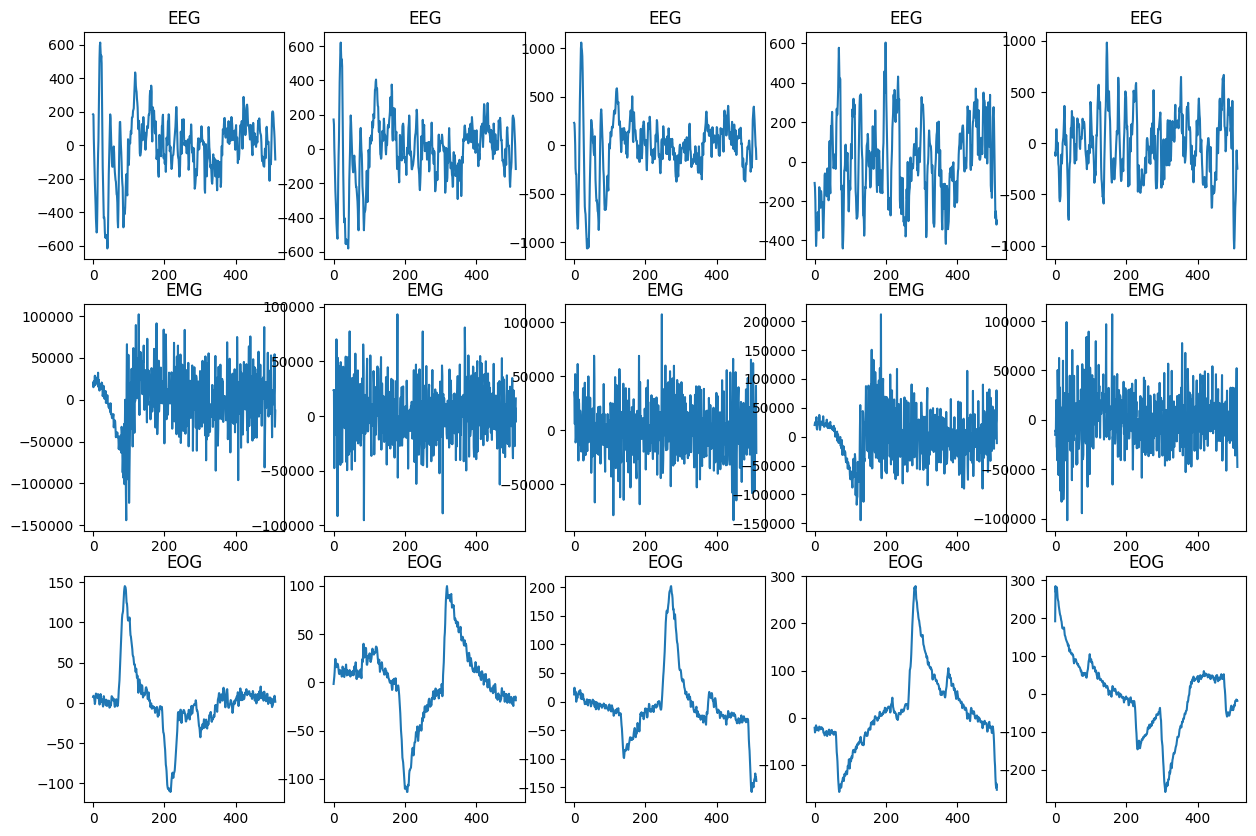

In [75]:
#LOADING DATA 

pure_EEG=np.load(os.path.join(data_path,'EEG_all_epochs.npy')) #load EEG pure data
pure_EMG=np.load(os.path.join(data_path,'EMG_all_epochs.npy')) #load EMG data
pure_EOG=np.load(os.path.join(data_path,'EOG_all_epochs.npy')) #load EOG data

fig, axs = plt.subplots(3, 5, figsize=(15, 10))
for i in range(5):
    axs[0,i].set_title('EEG')
    axs[0,i].plot(range(len(pure_EEG[i])),pure_EEG[i])

    axs[1,i].set_title('EMG')
    axs[1,i].plot(range(len(pure_EMG[i])),pure_EMG[i])
    
    axs[2,i].set_title('EOG')
    axs[2,i].plot(range(len(pure_EOG[i])),pure_EOG[i])
plt.show()

<h2 style=" font-size:150%; color:red;"> <b> 1.2 data preprocessing </b> </h2>
<div> In this section I will prepare the data to be used in the models.Specifically, we are going to create a dataset composed of:
<ol>
    <li> <b>EEG_raw_training_data</b>: 80% of the EEG signals </li>
    <li> <b>EEG_clean_training_data</b>: 80% of the clean EEG signals </li>
    <li> <b>EEG_raw_validation_data</b>: 10% of the EEG signals </li>
    <li> <b>EEG_clean_validation_data</b>: 10% of the clean EEG signals </li>
    <li> <b>EEG_raw_test_data</b>: 10% of the EEG signals </li>
    <li> <b>EEG_clean_test_data</b>: 10% of the clean EEG signals </li>  
</ol>
</div>
<div style="color:red" > <b> Note:</b> </div> <div> The process includes code from the <a href="https://github.com/ncclabsustech/EEGdenoiseNet">EEGdenoiseNet</a> repository. </div>


In [76]:
# Author: Haoming Zhang
#The code here not only include data importing, but also data standardization and the generation of analog noise signals


#PERFORMS THE STANDARD DEVIATION OF THE RECORDS
def get_std(records):
    return math.sqrt(sum([x ** 2 for x in records]) / len(records)) 


#AUGMENTS THE SIGNAL AND ADDS RANDOM DISTURB
def random_signal(signal,combin_num):   #signal= EEG data (?), combin_num= number of times we want to shuffle data (factor of which)
                                        #we want to augment our data
    random_result=[]

    for i in range(combin_num):
        random_num = np.random.permutation(signal.shape[0])     #creates a random shuffled list of integers from 0 to signal.shape[0]
        shuffled_dataset = signal[random_num,:]                #takes the elemnt of signal in the order we just shuffled
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0],signal.shape[1]) #reshapes it to have the sam eshap eof the original signal
        random_result.append(shuffled_dataset)                  #adds the shuffled signal to final result (we may want to repeat those steps to augment data)
    random_result  = np.array(random_result)

    return  random_result


#OBTAINING RAW DATA (training, validation and test)
def prepare_data(EEG_all, noise_all, combin_num, train_per, noise_type):    #EEG_all= original eeg data
                                                                            #noise_all= original noise data
                                                                            #combin_num= factor of which we wanto to augment data
                                                                            #train_per=percentage of data that we want to use as training [0,1]
                                                                            #noise_type= 'EMG' or 'EOG'

    EEG_all_random = np.squeeze(random_signal(signal = EEG_all, combin_num = 1))        #shuffling pure eeg
    noise_all_random = np.squeeze(random_signal(signal = noise_all, combin_num = 1))    #shuffling pure noise

    #If the noise type is EMG, EEG signal will be partially reused to match 'EMG signal' shape
    if noise_type == 'EMG':                  
        reuse_num = noise_all_random.shape[0] - EEG_all_random.shape[0] #we find the differenece of dimensions between EEG and EMG, n
        EEG_reuse = EEG_all_random[0 : reuse_num, :]                    #we select aportion of magnitude n from EEG
        EEG_all_random = np.vstack([EEG_reuse, EEG_all_random])         #stack original EEG  with that extra portion 
        print('EEG segments after reuse: ',EEG_all_random.shape[0])

    #If the noise type is EOG, EEG signal will be partially dropped to match 'EOG signal' shape
    elif noise_type == 'EOG':  
        EEG_all_random = EEG_all_random[0:noise_all_random.shape[0]]    #We drop some of the EEG signal to much the number of EMG
        print('EEG segments after drop: ',EEG_all_random.shape[0])


    #defining important data
    timepoint = noise_all_random.shape[1]                               #get the number of timestamps
    train_num = round(train_per * EEG_all_random.shape[0])              #the number of training points
    validation_num = round((EEG_all_random.shape[0] - train_num) / 2)   #the number of validation points
    test_num = EEG_all_random.shape[0] - train_num - validation_num     #the number of test points

    #splitting EEG in train,validation,test
    train_eeg = EEG_all_random[0 : train_num, :]
    validation_eeg = EEG_all_random[train_num : train_num + validation_num, :]
    test_eeg = EEG_all_random[train_num + validation_num : EEG_all_random.shape[0], :]

    #splittting EEG in train,validation,test
    train_noise = noise_all_random[0 : train_num, :]
    validation_noise = noise_all_random[train_num : train_num + validation_num,:]
    test_noise = noise_all_random[train_num + validation_num : noise_all_random.shape[0], :]

    #Augmenting training data and adding noise, with a factor of combin_num
    EEG_train = random_signal(signal = train_eeg, combin_num = combin_num).reshape(combin_num * train_eeg.shape[0], timepoint)
    NOISE_train = random_signal(signal = train_noise, combin_num = combin_num).reshape(combin_num * train_noise.shape[0], timepoint)

    #################################  simulate noise signal of training set  ##############################

    #creating random number between -10dB ~ 2dB
    SNR_train_dB = np.random.uniform(-7, 2, (EEG_train.shape[0]))   #samples randomly as many point as the ones in training set
    print(SNR_train_dB.shape)                                       #from the uniform distribution from -7 to 2
    SNR_train = 10 ** (0.1 * (SNR_train_dB))

    #combining eeg and noise for training set 
    noiseEEG_train=[]
    NOISE_train_adjust=[]
    for i in range (EEG_train.shape[0]):
        eeg=EEG_train[i].reshape(EEG_train.shape[1])        #for each sample reates a vector of EEG data
        noise=NOISE_train[i].reshape(NOISE_train.shape[1])  #and a vector of noise data

        coe=get_std(eeg)/(get_std(noise)*SNR_train[i])      #computes a mixing coefficient as the std of eeg divided by 
                                                            #the std of noise multiplied by the SNR (random noise?)
        noise = noise*coe           #multiply the noise by the coefficient
        neeg = noise+eeg            #add it to clean eeg to obtain raw data

        NOISE_train_adjust.append(noise)
        noiseEEG_train.append(neeg)

    noiseEEG_train=np.array(noiseEEG_train)                 #create an array with raw train EEg
    NOISE_train_adjust=np.array(NOISE_train_adjust)         #create an array with the noise we added to the pure eeg

    #dividing each epoch of training data (both raw and clean) for standard deviation
    EEG_train_end_standard = []
    noiseEEG_train_end_standard = []

    for i in range(noiseEEG_train.shape[0]):
        eeg_train_all_std = EEG_train[i] / np.std(noiseEEG_train[i])
        EEG_train_end_standard.append(eeg_train_all_std)

        noiseeeg_train_end_standard = noiseEEG_train[i] / np.std(noiseEEG_train[i])
        noiseEEG_train_end_standard.append(noiseeeg_train_end_standard)

    noiseEEG_train_end_standard = np.array(noiseEEG_train_end_standard)
    EEG_train_end_standard = np.array(EEG_train_end_standard)
    print('training data prepared', noiseEEG_train_end_standard.shape, EEG_train_end_standard.shape )

    #################################  simulate noise signal of validation  ##############################

    SNR_val_dB = np.linspace(-7.0, 2.0, num=(10))
    SNR_val = 10 ** (0.1 * (SNR_val_dB))

    eeg_val = np.array(validation_eeg)
    noise_val = np.array(validation_noise)
    
    # combin eeg and noise for test set 
    EEG_val = []
    noise_EEG_val = []
    for i in range(10):
        
        noise_eeg_val = []
        for j in range(eeg_val.shape[0]):
            eeg = eeg_val[j]
            noise = noise_val[j]
            
            coe = get_std(eeg) / (get_std(noise) * SNR_val[i])
            noise = noise * coe
            neeg = noise + eeg
            
            noise_eeg_val.append(neeg)
        
        EEG_val.extend(eeg_val)
        noise_EEG_val.extend(noise_eeg_val)


    noise_EEG_val = np.array(noise_EEG_val)
    EEG_val = np.array(EEG_val)


    # std for noisy EEG
    EEG_val_end_standard = []
    noiseEEG_val_end_standard = []
    # std_VALUE = []
    for i in range(noise_EEG_val.shape[0]):
        
        # store std value to restore EEG signal
        std_value = np.std(noise_EEG_val[i])
        #std_VALUE.append(std_value)

        # Each epochs of eeg and neeg was divide by the standard deviation
        eeg_val_all_std = EEG_val[i] / std_value
        EEG_val_end_standard.append(eeg_val_all_std)

        noiseeeg_val_end_standard = noise_EEG_val[i] / std_value
        noiseEEG_val_end_standard.append(noiseeeg_val_end_standard)

    #std_VALUE = np.array(std_VALUE)
    noiseEEG_val_end_standard = np.array(noiseEEG_val_end_standard)
    EEG_val_end_standard = np.array(EEG_val_end_standard)
    print('validation data prepared, validation data shape: ', noiseEEG_val_end_standard.shape, EEG_val_end_standard.shape)

    #################################  simulate noise signal of test  ##############################

    SNR_test_dB = np.linspace(-7.0, 2.0, num=(10))
    SNR_test = 10 ** (0.1 * (SNR_test_dB))

    eeg_test = np.array(test_eeg)
    noise_test = np.array(test_noise)
    
    # combin eeg and noise for test set 
    EEG_test = []
    noise_EEG_test = []
    for i in range(10):
        
        noise_eeg_test = []
        for j in range(eeg_test.shape[0]):
            eeg = eeg_test[j]
            noise = noise_test[j]
            
            coe = get_std(eeg) / (get_std(noise) * SNR_test[i])
            noise = noise * coe
            neeg = noise + eeg
            
            noise_eeg_test.append(neeg)
        
        EEG_test.extend(eeg_test)
        noise_EEG_test.extend(noise_eeg_test)


    noise_EEG_test = np.array(noise_EEG_test)
    EEG_test = np.array(EEG_test)


    # std for noisy EEG
    EEG_test_end_standard = []
    noiseEEG_test_end_standard = []
    std_VALUE = []
    for i in range(noise_EEG_test.shape[0]):
        
        # store std value to restore EEG signal
        std_value = np.std(noise_EEG_test[i])
        std_VALUE.append(std_value)

        # Each epochs of eeg and neeg was divide by the standard deviation
        eeg_test_all_std = EEG_test[i] / std_value
        EEG_test_end_standard.append(eeg_test_all_std)

        noiseeeg_test_end_standard = noise_EEG_test[i] / std_value
        noiseEEG_test_end_standard.append(noiseeeg_test_end_standard)

    std_VALUE = np.array(std_VALUE)
    noiseEEG_test_end_standard = np.array(noiseEEG_test_end_standard)
    EEG_test_end_standard = np.array(EEG_test_end_standard)
    print('test data prepared, test data shape: ', noiseEEG_test_end_standard.shape, EEG_test_end_standard.shape)

    return noiseEEG_train_end_standard, EEG_train_end_standard, noiseEEG_val_end_standard, EEG_val_end_standard, noiseEEG_test_end_standard, EEG_test_end_standard, std_VALUE

<h2 style=" font-size:150%; color:red ;"> <b> 1.3 splitting in train, val, test</b> </h2>

In [77]:
#CREATING THE WHOLE TRAING VALIDATION AND TEST DATABASE
#for each pure EEg we are going to select 100 pure EMG and 100 pure EOG and obtained resulting raw data
#at the end we will have 4514*200 tuples o f(raw_eeg_train, clean_eeg_train, raw_eeg_val, clean_eeg_val, raw_eeg_test, clean_eeg_test)
train_dataset=[[],[]]
validation_dataset=[[],[]]
test_dataset=[[],[]]

train_dataset_EMG=[[],[]]
validation_dataset_EMG=[[],[]]
test_dataset_EMG=[[],[]]

train_dataset_EOG=[[],[]]
validation_dataset_EOG=[[],[]]
test_dataset_EOG=[[],[]]

#for element in pure_EEG:
#combining the EEg with 100 random EMG
#for i in np.random.randint(0,len(pure_EMG),100):
noiseEEG_train, EEG_train, noiseEEG_val, EEG_val, noiseEEG_test, EEG_test, test_std_VALUE = prepare_data(EEG_all = pure_EEG, noise_all = pure_EMG, combin_num = 10, train_per = 0.8, noise_type = 'EMG')
train_dataset_EMG[0]=noiseEEG_train
train_dataset_EMG[1]=EEG_train
validation_dataset_EMG[0]=noiseEEG_val
validation_dataset_EMG[1]=EEG_val
test_dataset_EMG[0]=noiseEEG_test
test_dataset_EMG[1]=EEG_test

#combining the EEG with 100 random EOG
#for i in np.random(0,len(pure_EOG),100):
noiseEEG_train, EEG_train, noiseEEG_val, EEG_val, noiseEEG_test, EEG_test, test_std_VALUE = prepare_data (EEG_all = pure_EEG, noise_all = pure_EOG, combin_num = 10, train_per = 0.8, noise_type = 'EOG')
train_dataset_EOG[0]=noiseEEG_train
train_dataset_EOG[1]=EEG_train
validation_dataset_EOG[0]=noiseEEG_val
validation_dataset_EOG[1]=EEG_val
test_dataset_EOG[0]=noiseEEG_test
test_dataset_EOG[1]=EEG_test

#creating a mixed dataset
train_dataset[0]=np.vstack((train_dataset_EMG[0],train_dataset_EOG[0]))
train_dataset[1]=np.vstack((train_dataset_EMG[1],train_dataset_EOG[1]))
validation_dataset[0]=np.vstack((validation_dataset_EMG[0],validation_dataset_EOG[0]))
validation_dataset[1]=np.vstack((validation_dataset_EMG[1],validation_dataset_EOG[1]))
test_dataset[0]=np.vstack((test_dataset_EMG[0],test_dataset_EOG[0]))
test_dataset[1]=np.vstack((test_dataset_EMG[1],test_dataset_EOG[1]))


print('the number of total (EMG and EOG noise added) training saples is',len(train_dataset[0]))

EEG segments after reuse:  5598
(44780,)
training data prepared (44780, 512) (44780, 512)
validation data prepared, validation data shape:  (5600, 512) (5600, 512)
test data prepared, test data shape:  (5600, 512) (5600, 512)
EEG segments after drop:  3400
(27200,)
training data prepared (27200, 512) (27200, 512)
validation data prepared, validation data shape:  (3400, 512) (3400, 512)
test data prepared, test data shape:  (3400, 512) (3400, 512)
the number of total (EMG and EOG noise added) training saples is 71980


<h2 style=" font-size:180%; color:red; text-align:center;"> <b> 2. METRICS AND LEARNING PARAMETERS </b> </h2>

<h2 style=" font-size:150%; color:red;"> <b> 2.1. metrics </b> </h2>

<div style="size 80%; ">Calculate the metrics as follows: 
<ul>
    <li> <b>SNR</b>: Signal to Noise Ratio </li>
    <li> <b>PSNR</b>: Peak Signal to Noise Ratio </li>
    <li> <b>SSIM</b>: Structural Similarity Index </li>
    <li> <b>RMS></b>: Root Mean Square </li>
    <li> <b>RRMSE</b>: Relative Root Mean Square Error </li>
</ul>
 the formula for each metric is: 
<ul>
    <li> <b>SNR</b>: 10 * log10((∑(x_i^2)) / (∑((x_i - x̂_i)^2))) </li>
    <li> <b>PSNR</b>: 10 * log10((MAX^2) / MSE) </li>
    <li> <b>SSIM</b>:  [(2μ_xμ_x̂ + c_1)(2σ_{x x̂} + c_2)] / [(μ_x^2 + μ_x̂^2 + c_1)(σ_x^2 + σ_x̂^2 + c_2)] </li>
    <li> <b>RMS</b>: sqrt((1/N) * ∑((x_i - x̂_i)^2)) </li>
    <li> <b>RRMSE</b>: RMS(x-x̂) / RMS(x) </li>
</ul>
</div>

In [78]:
#CALCULATE RRMSE, PSNR, SSIM
def RMS(x):
        len=np.shape(x)[1]
        sum_=np.sum(x**2,axis=1)
        return np.sqrt(sum_/len)
def metrics_results(denoised, clear):
    #calculate the RRMSE
    max_clear=np.max(clear,axis=1)
  
    print('RMS of the clear signal is',RMS(clear))
    print('RMS of the clear minus denoised signal is',RMS(clear-denoised))
    #calculate the RRMSE
    #subtract the denoised from the clear
    sub=np.subtract(clear,denoised)
    RRMSE_values = RMS(sub)/RMS(clear)
    print('RRMSE values are',RRMSE_values)
    RRMSE=np.mean(RRMSE_values)

    #calculate the CC
    CC_values = np.zeros((denoised.shape[0],1))
    for i in range(denoised.shape[0]):
        CC_values[i] = np.corrcoef(np.array(denoised[i,:]),np.array(clear[i,:]))[0,1]
    CC=np.mean(CC_values)

    #calculate the PSNR
    mse_values=np.mean((denoised- clear)**2, axis=1)
    PSNR_values = 10 * np.log10(max_clear**2/mse_values)
    PSNR=np.mean(PSNR_values)


    from skimage.metrics import structural_similarity as ssim
    #calculate the SSIM
    SSIM_values = np.zeros((denoised.shape[0],1))
    for i in range(denoised.shape[0]):
        SSIM_values[i] = ssim(np.array(denoised[i,:]),np.array(clear[i,:]),data_range=max_clear[i])
    SSIM=np.mean(SSIM_values)
    
    return RRMSE, CC, PSNR, SSIM

<h2 style=" font-size:150%; color:red;"> <b> 2.2 loss function and optimizer </b> </h2>

In [79]:
import time 
#loss function
def loss_function(y_true, y_pred):
    loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    return loss

#optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


<h2 style=" font-size:150%; color:red;"> <b> 2.3 training function </b> </h2>


In [80]:
def train_model(model, dataset, val_dataset, noise_type, model_name, results_path, epochs=60, batch_size=1):
    input = np.reshape(dataset[0],(len(dataset[0]),1,512))
    target = np.reshape(dataset[1],(len(dataset[1]),1,512))
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    #reshape validation data
    val_input= np.reshape(val_dataset[0],(len(val_dataset[0]),1,512))
    val_target= np.reshape(val_dataset[1],(len(val_dataset[1]),1,512))
    trained_model=model.fit((input, input), target, epochs, batch_size, verbose=1, validation_data=((val_input, val_input), val_target))

    #save the trained model
    model.save_weights(os.path.join(results_path, model_name, noise_type,'model'))
    #save the history (create the file if it doesn't exist)
    if not os.path.exists(os.path.join(results_path, model_name, noise_type, 'history.csv')):
        with open(os.path.join(results_path, model_name, noise_type, 'history.csv'), 'w') as f:
            f.write('loss,accuracy,val_loss,val_accuracy\n')
    #save the history
    with open(os.path.join(results_path, model_name, noise_type, 'history.csv'), 'a') as f:
        for i in range(len(trained_model.history['loss'])):
            f.write(str(trained_model.history['loss'][i])+','+str(trained_model.history['accuracy'][i])+','+str(trained_model.history['val_loss'][i])+','+str(trained_model.history['val_accuracy'][i])+'\n')

    #return the trained model
    return trained_model


<h1 style=" font-size:180%; color:red; text-align:center;"> <b> 3. PROPOSED MODEL </b> </h1>

<h2 style=" font-size:150%; color:red;"> <b> 3.1 personalized layers</b> </h2>

In [81]:

from tensorflow.keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout, MultiHeadAttention, Embedding
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
 
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

<h2 style=" font-size:150%; color:red;"> <b> 3.2 encoder and decoder architecture </b> </h2>

In [82]:
#CRETING AN ENCODER
class Encoder(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation="relu"),
            Dense(d_model),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
 
    def call(self, inputs, training):
        attn_output = self.mha(inputs, inputs) # self-attention
        attn_output = self.dropout1(attn_output, training=training)# dropout
        out1 = self.layernorm1(inputs + attn_output) # add and norm
 
        ffn_output = self.ffn(out1) # point-wise feed forward
        ffn_output = self.dropout2(ffn_output, training=training) # dropout
        return self.layernorm2(out1 + ffn_output)   # add and norm
 
    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'rate': self.rate,
        })
        return config

#Calling the encoder
encoder = Encoder(d_model=512, num_heads=8, dff=512, rate=0.1)

#reshaping train_dataset_EOG[0] into batch_size, input_seq_len, d_model
train_dataset_EOG[0]=np.reshape(train_dataset_EOG[0],(len(train_dataset_EOG[0]),1,512))

#executing the encoder
sample_encoder_output = encoder(train_dataset_EOG[0], training=False)
print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

#CREATING A DECODER
class Decoder(Layer):

    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation="relu"),
            Dense(d_model),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)
 
    def call(self, inputs, encoder_outputs, training):
        attn1 = self.mha1(inputs, inputs) # self-attention
        attn1 = self.dropout1(attn1, training=training) # dropout
        out1 = self.layernorm1(inputs + attn1) # add and norm
 
        attn2 = self.mha2(out1, encoder_outputs) # encoder-decoder attention
        attn2 = self.dropout2(attn2, training=training) # dropout
        out2 = self.layernorm2(out1 + attn2) # add and norm
 
        ffn_output = self.ffn(out2) # point-wise feed forward
        ffn_output = self.dropout3(ffn_output, training=training) # dropout
        return self.layernorm3(out2 + ffn_output) # add and norm
 
    def get_config(self):
        config = super(Decoder, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'rate': self.rate,
        })
        return config

#Calling the decoder
decoder = Decoder(d_model=512, num_heads=8, dff=512, rate=0.1)

#reshaping train_dataset_EOG[0] into batch_size, input_seq_len, d_model
train_dataset_EOG[0]=np.reshape(train_dataset_EOG[0],(len(train_dataset_EOG[0]),1,512))

#executing the decoder
sample_decoder_output = decoder(train_dataset_EOG[0], sample_encoder_output, training=False)
print(sample_decoder_output.shape)  # (batch_size, target_seq_len, d_model)

(27200, 1, 512)
(27200, 1, 512)


<h2 style=" font-size:150%; color:red;"> <b> 3.3 transformer model </b> </h2>

In [83]:
#CREATING THE TRANSFORMER
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, rate=0.1, **kwargs):
        super(Transformer, self).__init__(**kwargs)
        self.num_layers=num_layers
        self.d_model=d_model
        self.d_model=d_model
        self.num_heads=num_heads
        self.dff=dff
        self.input_vocab_size=input_vocab_size
        self.target_vocab_size=target_vocab_size
        self.rate=rate
        self.encoder = Encoder(d_model, num_heads, dff, rate)
        self.decoder = Decoder(d_model, num_heads, dff, rate)
        self.final_layer = Dense(target_vocab_size)
 
    def call(self, inputs, training):
        inp, tar = inputs
        enc_output = self.encoder(inp, training)
        dec_output = self.decoder(tar, enc_output, training)
        final_output = self.final_layer(dec_output)
        return final_output

    def get_config(self):
        config = super(Transformer, self).get_config()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'input_vocab_size': self.input_vocab_size,
            'target_vocab_size': self.target_vocab_size,
            'rate': self.rate,
        })
        return config


<h2 style=" font-size:180%; color:red; text-align:center;"> <b> 4. EXPERIMENTS </b> </h2>

<h2 style=" font-size:150%; color:red;"> <b> 4.1 EOG denoising </b> </h2>

In [84]:
#building the transformer
model_EOG =Transformer(num_layers=2, d_model=512, num_heads=8, dff=512, input_vocab_size=512, target_vocab_size=512, rate=0.1)

In [85]:
#TRAINING THE TRANSFORMER
#train the model
trained_model_EOG = train_model(model_EOG, train_dataset_EOG, validation_dataset_EOG, 'EOG', 'transformer_simple', results_path, epochs=50, batch_size=1)

13600/13600 [==============================] - 158s 11ms/step - loss: 0.2790 - accuracy: 0.0197 - val_loss: 0.2696 - val_accuracy: 0.0209


<h1> plot the history <h1>

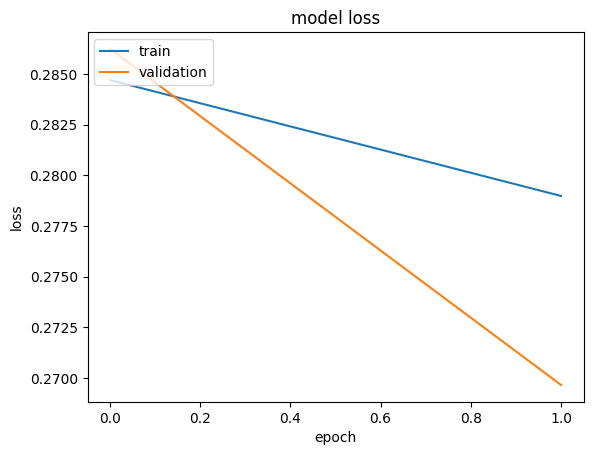

In [86]:
#read history csv
history_EOG = pd.read_csv(os.path.join(results_path, 'transformer_simple', 'EOG', 'history.csv'))
#plot the loss
plt.plot(history_EOG['loss'])
plt.plot(history_EOG['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(results_path, 'transformer_simple', 'EOG', 'loss.png'))

In [87]:

#load the model
#load weights
model_EOG.load_weights(os.path.join(results_path, 'transformer_simple', 'EOG', 'model'))

In [88]:
#import skimage

#predict the test dataset
test_dataset_EOG[0]=np.reshape(test_dataset_EOG[0],(len(test_dataset_EOG[0]),1,512))
pred_EOG=model_EOG((test_dataset_EOG[0], test_dataset_EOG[0]), training=False)

#evaluate the model
loss, accuracy=model_EOG.evaluate((test_dataset_EOG[0], test_dataset_EOG[0]), pred_EOG, verbose=1)
#plot the loss and accuracy
print('loss:',loss)
print('accuracy:',accuracy)

#calculate the metrics
pred_EOG=np.reshape(pred_EOG,(len(pred_EOG),512))
test_dataset_EOG[1]=np.reshape(test_dataset_EOG[1],(len(test_dataset_EOG[1]),512))

#print the two shapes
print('pred shape:',pred_EOG.shape)
print('test shape:',test_dataset_EOG[1].shape)
RRMSE, CC, PSNR, SSIM=metrics_results(pred_EOG, test_dataset_EOG[1])
print('RRMSE:',RRMSE,'CC:',CC,'PSNR:',PSNR,'SSIM',SSIM)

107/107 [==============================] - 1s 7ms/step - loss: 2.2072e-14 - accuracy: 1.0000
loss: 2.2071954046366457e-14
accuracy: 1.0
pred shape: (3400, 512)
test shape: (3400, 512)
RMS of the clear signal is [0.19821916 0.19377228 0.20605207 ... 0.80922935 0.87857805 0.87164963]
RMS of the clear minus denoised signal is [0.18135076 0.19295671 0.30875781 ... 0.74889684 0.72805741 0.86253772]
RRMSE values are [0.91490027 0.9957911  1.49844557 ... 0.92544449 0.82867699 0.98954636]
RRMSE: 0.9488760461399267 CC: 0.3645288395610643 PSNR: 10.0987607007403 SSIM 0.04555870113383705


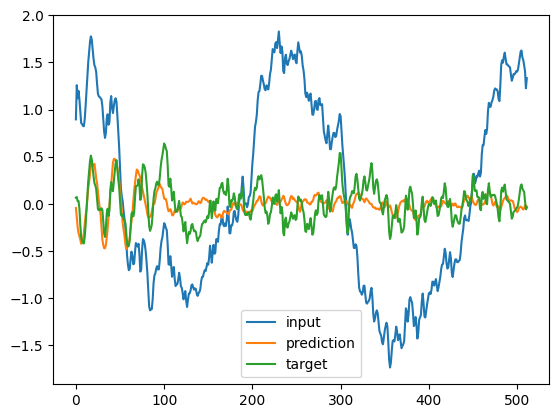

In [89]:
#plot a semple result of the prediction vs the target
#plot a semple result of the prediction vs the target vs the input
#reshape the input
test_dataset_EOG[0]=np.reshape(test_dataset_EOG[0],(len(test_dataset_EOG[0]),512))

plt.plot(test_dataset_EOG[0][0], label='input')
plt.plot(pred_EOG[0], label='prediction')
plt.plot(test_dataset_EOG[1][0], label='target')

plt.legend()
plt.show()


<h2 style=" font-size:150%; color:red;"> <b> 4.2 EMG denoising</b> </h2>

In [90]:
#create the model
model_EMG =Transformer(num_layers=2, d_model=512, num_heads=8, dff=512, input_vocab_size=512, target_vocab_size=512, rate=0.1)

#calling the train_transformer function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


In [94]:
#TRAINING THE TRANSFORMER
#train the model
trained_model_EMG = train_model(model_EMG, train_dataset_EMG, validation_dataset_EMG, 'EMG', 'transformer_simple', results_path, epochs=50, batch_size=1)

14927/14927 [==============================] - 223s 15ms/step - loss: 0.1751 - accuracy: 0.0879 - val_loss: 0.1311 - val_accuracy: 0.1407


<h1> plot the history <h1>


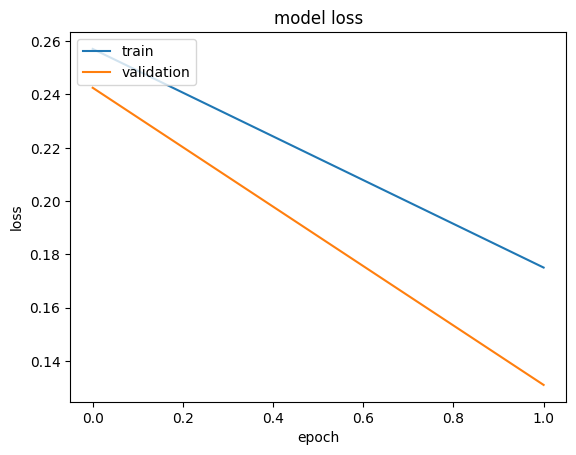

In [95]:
#read history csv
history_EMG = pd.read_csv(os.path.join(results_path, 'transformer_simple', 'EMG', 'history.csv'))
#plot the loss
plt.plot(history_EMG['loss'])
plt.plot(history_EMG['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(results_path, 'transformer_simple', 'EMG', 'loss.png'))

In [96]:
#load the model
model_EMG.load_weights(os.path.join(results_path,'transformer_simple','EMG', 'model'))

In [97]:
#predict the test dataset
test_dataset_EMG[0]=np.reshape(test_dataset_EMG[0],(len(test_dataset_EMG[0]),1,512))
pred_EMG=model_EMG((test_dataset_EMG[0], test_dataset_EMG[0]), training=False)
#calculate the metrics
pred_EMG=np.reshape(pred_EMG,(len(pred_EMG),512))
test_dataset_EMG[1]=np.reshape(test_dataset_EMG[1],(len(test_dataset_EMG[1]),512))
RRMSE, CC, PSNR, SSIM=metrics_results(pred_EMG, test_dataset_EMG[1])
print('RRMSE:',RRMSE,'CC:',CC,'PSNR:',PSNR,'SSIM',SSIM)

RMS of the clear signal is [0.19510373 0.19358068 0.19562445 ... 0.89077315 0.85001817 0.8257134 ]
RMS of the clear minus denoised signal is [0.33192443 0.29390005 0.20664346 ... 0.48423284 0.49069459 0.37372172]
RRMSE values are [1.70127158 1.51823027 1.05632737 ... 0.54360961 0.57727541 0.45260464]
RRMSE: 0.7655785658570793 CC: 0.694598462900914 PSNR: 12.348082414031913 SSIM 0.21719941638417273


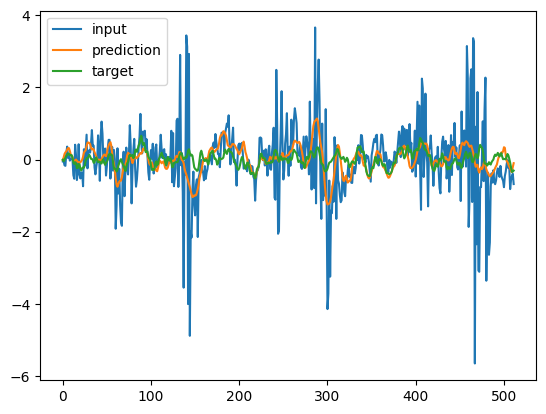

In [98]:

#plot a semple result of the prediction vs the target
#plot a semple result of the prediction vs the target vs the input
#reshape the input
test_dataset_EMG[0]=np.reshape(test_dataset_EMG[0],(len(test_dataset_EMG[0]),512))

plt.plot(test_dataset_EMG[0][0], label='input')
plt.plot(pred_EMG[0], label='prediction')
plt.plot(test_dataset_EMG[1][0], label='target')

plt.legend()
plt.show()
